## Multiplication

A quick and easy example to start off with is to build a toy model which takes in two numbers, and outputs the result. Although the model doesn't accomplish anything significant the same techniques can be used to model and train much larger and complex networks.

`Numpy` is seeded to allow deterministic results, this seeding has no relevance to the architecture or the training of the network

In [27]:
%matplotlib inline

import nengo
import tensorflow as tf
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

np.random.seed(0)

### Architecture

The architecture chosen is somewhat arbitrary, you can see the details of the connections here:
![Image of NN Architecture](http://i.imgur.com/LS8j8Ti.png)


We connect two input nodes (`i_1`, `i_2`), both of which generate random numbers, to two ensembles (`a`, `b`). Then these ensembles are connected to a third ensemble (`c`) which we probe for the output.

In [34]:
with nengo.Network() as net:
    
    
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)
    net.config[nengo.Connection].synapse = None
    
    i_1 = nengo.Node(output=lambda t: np.random.random())
    i_2 = nengo.Node(output=lambda t: np.random.random())

    a = nengo.Ensemble(100, 1)
    b = nengo.Ensemble(100, 1)
    nengo.Connection(i_1, a)
    nengo.Connection(i_2, b)
    
    c = nengo.Ensemble(220, 1)
    nengo.Connection(a, c)
    nengo.Connection(b, c)
    
    i_1_probe = nengo.Probe(i_1)
    i_2_probe = nengo.Probe(i_2)
    output_probe = nengo.Probe(c)

Before we train the network the output isn't complete random noise, from a first glance it seems to be roughly adding the two inputs. However we don't want that output, so we need to train the network to multiply the inputs instead of adding them.

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00


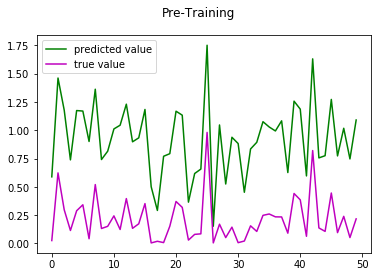

In [38]:
n_steps = 50
minibatch_size = 100
# Showing the output of the model pre training
with nengo_dl.Simulator(net) as sim:
    sim.run_steps(n_steps)
    true_value = np.multiply(sim.data[i_1_probe], sim.data[i_2_probe])
    fig = plt.figure()
    fig.suptitle('Pre-Training')
    plt.plot(sim.data[output_probe], 'g', label='predicted value')
    plt.plot(true_value, 'm', label='true value')
    plt.legend()

To train the network we generate training feeds which consist of two batches of random numbers (the inputs) and then the result of those batches multiplied together (the outputs). Additionally we generate some test data to easily track the progress of the network throughout training. 

In [52]:
with nengo_dl.Simulator(net, step_blocks=n_steps, minibatch_size=minibatch_size, device="/cpu:0") as sim:
    # This feed is used as the "test" data
    # It's run through the network after every iteration 
    # to allow easy visulization of how the output is changing
    test_input_feed = {i_1: np.random.uniform(0, 1, size=(100, n_steps, 1)),
                  i_2: np.random.uniform(0, 1, size=(100, n_steps, 1))}
    test_output = np.multiply(test_input_feed[i_1], test_input_feed[i_2])    
    # The outputs of the network after every it
    outputs = []
    sim.run_steps(n_steps, input_feeds=test_input_feed)  
    outputs.append((sim.data[output_probe][0].flatten()))
    # running through 5 rounds of training, then testing
    for i in range(0, 5):
        input_feed = {i_1: np.random.uniform(0, 1, size=(1000, n_steps, 1)),
                      i_2: np.random.uniform(0, 1, size=(1000, n_steps, 1))}
        output_feed = {output_probe: np.multiply(input_feed[i_1], input_feed[i_2])}
        sim.train(input_feed, output_feed,
                 tf.train.MomentumOptimizer(5e-3, 0.9), n_epochs=2)
        sim.soft_reset(include_probes=True)
        sim.run_steps(n_steps, input_feeds=test_input_feed)
        print("LOSS: " + str(sim.loss(test_input_feed, {output_probe: test_output}, 'mse')))
        outputs.append((sim.data[output_probe][0].flatten()))

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:06
Simulation completed in 0:00:00
LOSS: 0.0351923257113
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:06
Simulation completed in 0:00:00
LOSS: 0.0107377879322
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:06
Simulation completed in 0:00:00
LOSS: 0.00956948567182
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:06
Simulation completed in 0:00:00
LOSS: 0.00912853609771
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:06
Simulation completed in 0:00:00
LOSS: 0.00870980415493


We visualize the results by plotting the pre-trained, trained and ideal outputs next to each other

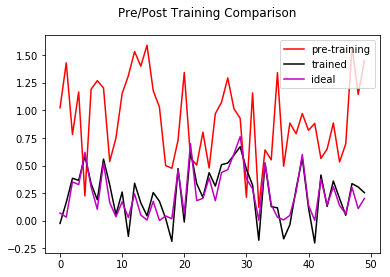

In [54]:
fig = plt.figure()
fig.suptitle('Pre/Post Training Comparison')
plt.plot(outputs[0], 'r', label='pre-training')
plt.plot(outputs[5], 'k', label='trained')
plt.plot(test_output[0], 'm', label='ideal')
plt.legend()